In [321]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
from scipy.integrate import quad,simps, dblquad, cumtrapz
from chainconsumer import ChainConsumer
import pyccl as ccl
import time
%load_ext autoreload
%autoreload 2
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/')
import CL_COUNT_class_cluster_abundance as cl_count
import DATAOPS_Fisher_matrix as fisher
forecast = fisher.Forecast()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [326]:
x = np.linspace(0,1,1000)
y = np.exp(-x)
t0 = time.time()
integer = simps(y, x)
print(integer)
t1 = time.time()
print(t1-t0)
t0 = time.time()
integer = cumtrapz(y, x)[-1]
print(integer)
t1 = time.time()
print(t1-t0)

0.6321205588857143
0.0009167194366455078
0.6321206116107809
0.0005815029144287109


# Define model

In [297]:
#define binning for Binned likelihood
z_corner = np.linspace(0.01, 2, 21)
logm_corner = np.linspace(14, 15, 6)
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
Z_bin = binning(z_corner)
logMass_bin = binning(logm_corner)

In [298]:
#define redshift-mass grid
z_grid = np.linspace(0., 3, 1003)
logm_grid = np.linspace(12,16, 1000)

In [299]:
#Define modeling for cluster abundance
CA = cl_count.ClusterAbundance()
CA.f_sky = .25
CA.sky_area = CA.f_sky*4*np.pi
#Omega_c_true = 0.1109/(0.71**2)
#Omega_b_true = 0.02258/(0.71**2)
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
cosmo_true = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.71, sigma8 = sigma8_true, n_s=0.96)
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
#define mass definition/halo mass function/halo bias
massdef = ccl.halos.massdef.MassDef('vir', 'critical', c_m_relation=None)
hmd = ccl.halos.MassFuncDespali16(cosmo_true, mass_def=massdef)
halobais = ccl.halos.hbias.HaloBiasTinker10(cosmo_true, mass_def=massdef, mass_def_strict=True)
CA.set_cosmology(cosmo = cosmo_true, hmd = hmd, massdef = massdef)
#calculate interpolated multiplicity function
CA.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
#compute predicted cluster abundance in Z_bin and logMass_bin
N_th_true_cosmo = CA.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')

In [300]:
def model(theta):
    Omegab = Omega_b_true
    Omegam, sigma8 = theta
    cosmo_new = ccl.Cosmology(Omega_c = Omegam - Omegab, Omega_b = Omegab, h = 0.71, sigma8 = sigma8, n_s=0.96)
    hmd_new = ccl.halos.MassFuncDespali16(cosmo_new, mass_def=massdef)
    CA.set_cosmology(cosmo = cosmo_new, hmd = hmd_new, massdef = massdef)
    CA.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
    N_th = CA.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')
    return N_th.flatten()

# Binned

## Poissonian

In [301]:
cov_SN_true_cosmo = np.diag(N_th_true_cosmo.flatten())

## Poissonian + SSC covariance matrix

In [302]:
sys.path.append('/pbs/throng/lsst/users/cpayerne/PySSC/')
import PySSC

In [303]:
z_arr = np.linspace(.10,2.3,1000)
nbins_T   = len(z_corner)-1
windows_T = np.zeros((nbins_T,len(z_arr)))
for i, z_bin in enumerate(Z_bin):
    Dz = z_bin[1]-z_bin[0]
    z_arr_cut = z_arr[(z_arr > z_bin[0])*(z_arr < z_bin[1])]
    for k, z in enumerate(z_arr):
        if ((z>z_bin[0]) and (z<=z_bin[1])):
            windows_T[i,k] = 1/Dz

In [304]:
Sij = PySSC.Sij(z_arr,windows_T)

In [305]:
LogM, Z = np.meshgrid(np.mean(logMass_bin, axis = 1), np.mean(Z_bin, axis = 1))
index_LogM, index_Z =  np.meshgrid(np.arange(len(logMass_bin)), np.arange(len(Z_bin)))

In [306]:
def SSC(logMass_bin, Z_bin):
    len_mat = len(Z_bin)*len(logMass_bin)
    cov_SSC = np.zeros([len_mat, len_mat])
    for i, Ni in enumerate(N_th_true_cosmo.flatten()):
        z_mean_i = Z.flatten()[i]
        index_z_i = index_Z.flatten()[i]
        logm_mean_i = LogM.flatten()[i]
        for j, Nj in enumerate(N_th_true_cosmo.flatten()):
            z_mean_j = Z.flatten()[j]
            index_z_j = index_Z.flatten()[j]
            logm_mean_j = LogM.flatten()[j]
            hbi = halobais.get_halo_bias(cosmo_true, 10**logm_mean_i, 1/(1 + z_mean_i), mdef_other = massdef)
            hbj = halobais.get_halo_bias(cosmo_true, 10**logm_mean_j, 1/(1 + z_mean_j), mdef_other = massdef)
            cov_SSC[i,j] = hbi * hbj * Ni * Nj * Sij[index_z_i,index_z_j]
    return cov_SSC/CA.f_sky

In [307]:
cov_SSC = SSC(logMass_bin, Z_bin)

In [308]:
cov_SN = np.diag(N_th_true_cosmo.flatten())
cov_SN_SV = np.diag(N_th_true_cosmo.flatten()) + cov_SSC

## MVP

In [309]:
%load_ext autoreload
import pickle
%autoreload 2
from scipy.stats import poisson
import CL_COUNT_MVP_cluster_abundance_prediction as mvp
import DATAOPS_Fisher_matrix as fisher

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [310]:
N_th_true_cosmo = CA.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps').flatten()

In [177]:
cov_tot_diag = cov_SN_SV.diagonal()
cov_SSC_diag = cov_SSC.diagonal()

In [178]:
from scipy.stats import poisson

In [215]:
%load_ext autoreload
import pickle
%autoreload 2
import CL_COUNT_MVP_cluster_abundance_prediction as mvp
import DATAOPS_Fisher_matrix as fisher

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [180]:
def ln_P_mvp_grid(theta):
    Omegab = Omega_b_true
    Omegam, sigma8 = theta
    cosmo_new = ccl.Cosmology(Omega_c = Omegam - Omegab, Omega_b = Omegab, h = 0.71, sigma8 = sigma8, n_s=0.96)
    hmd_new = ccl.halos.MassFuncDespali16(cosmo_new, mass_def=massdef)
    CA.set_cosmology(cosmo = cosmo_new, hmd = hmd_new, massdef = massdef)
    CA.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
    N_th = CA.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps').flatten()
    n_sigma=4
    n_max= round(max(N_th_true_cosmo  + n_sigma*np.sqrt(N_th_true_cosmo + cov_SSC_diag)))
    P_mvp_grid_array = np.zeros([len(N_th_true_cosmo), n_max])
    for i, nth in enumerate(N_th):
        min_ = max(0, round(nth - n_sigma*np.sqrt(nth + cov_SSC_diag[i])))
        max_ = min(n_max - 1, round(nth + n_sigma*np.sqrt(nth + cov_SSC_diag[i])))
        N_array = np.arange(min_, max_)
        P_mvp_grid_array[i,:][N_array] = mvp.P_MVP(N_array = N_array, mu = nth, var = cov_SSC_diag[i], method = 'simps')
    return np.log(P_mvp_grid_array)

In [250]:
mu = [1]
SSC_variance = [.1]

In [251]:
mat_res = np.zeros([len(mu), len(SSC_variance)])

In [280]:
%load_ext autoreload
import pickle
%autoreload 2
import CL_COUNT_MVP_cluster_abundance_prediction as mvp
import DATAOPS_Fisher_matrix as fisher

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[9.71319112e-01 2.43497397e-02 4.74360410e-04 7.73608730e-06
 1.09470528e-07]
[7.55557484e-01 1.91491926e-01 3.76575855e-02 6.23913523e-03
 9.03628229e-04 1.16852220e-04 1.36743759e-05]


/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/CL_COUNT_MVP_cluster_abundance_prediction.py:70: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return np.array(P_MVP)/K
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/CL_COUNT_MVP_cluster_abundance_prediction.py:70: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return np.array(P_MVP)/K
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/CL_COUNT_MVP_cluster_abundance_prediction.py:70: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return np.array(P_MVP)/K
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/CL_COUNT_M

[2.93696698e-03 8.39574464e-03 1.68390665e-02 2.83543182e-02
 4.21448919e-02 5.67134149e-02 7.02417095e-02 8.10186694e-02
 8.78008608e-02 9.00179767e-02 8.77954683e-02 8.18249713e-02
 7.31473771e-02 6.29190315e-02 5.22157585e-02 4.19039708e-02
 3.25836348e-02 2.45906882e-02 1.80384635e-02 1.28772830e-02
 8.95571966e-03 6.07310370e-03 4.01857825e-03 2.59625027e-03
 1.63849527e-03 1.01050736e-03 6.09210084e-04 3.59119692e-04
 2.07036618e-04 1.16752985e-04 6.44124087e-05 3.47707858e-05
 1.83680795e-05]


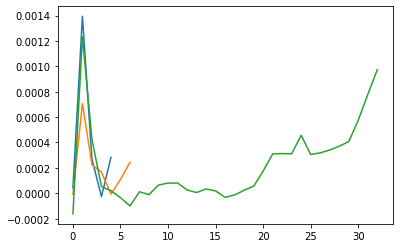

In [281]:
mu = np.logspace(-3,1,3)
SSC_variance = np.logspace(-3,1,3)
n_max = round(1e6)
for mu_, SSC_variance_ in zip(mu, SSC_variance):
    nth = mu_
    n_sigma = 4
    min_ = max(0, round(nth - n_sigma*np.sqrt(nth + SSC_variance_)))
    max_ = min(n_max - 1, round(nth + n_sigma*np.sqrt(nth + SSC_variance_)) + 5)
    N_array = np.arange(min_, max_)
    p_simps = mvp.P_MVP(N_array = N_array, mu = nth, var = SSC_variance_, method = 'simps')
    p_simps = p_simps
    p_true = mvp.P_MVP(N_array = N_array, mu = nth, var = SSC_variance_, method = 'quad_interp')
    p_true = p_true
    print(p_simps)
    #plt.plot(N_array, 100*(p_true - p_simps)/p_true)
    plt.plot(N_array, 100*(p_simps-p_true)/p_true)
#plt.plot(N_array, p_true)
    #print(p_true)
#plt.plot(N_array, 100*(p_true-p_simps)/p_true)
  #  plt.loglog()
    #plt.yscale('log')

# fisher matrix

## using second derivative

In [ ]:
ln_P = ln_P_mvp_grid(True_value)

In [125]:
forecast = fisher.Forecast()
second_derivative_ln_P = forecast.second_derivative(True_value, ln_P_mvp_grid, ln_P.shape, delta = 1e-5)

(2, 2, 100, 17877)


/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/DATAOPS_Fisher_matrix.py:55: RuntimeWarning: invalid value encountered in subtract
  2*model(theta) + \
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/DATAOPS_Fisher_matrix.py:56: RuntimeWarning: invalid value encountered in add
  model(theta-delta_i))/delta**2
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/DATAOPS_Fisher_matrix.py:60: RuntimeWarning: invalid value encountered in subtract
  model(theta-delta_i+delta_j) + \
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/DATAOPS_Fisher_matrix.py:61: RuntimeWarning: invalid value encountered in add
  model(theta-delta_i-delta_j))/(4*delta**2)


In [126]:
second_derivative_ln_P = np.where(np.invert(np.isnan(second_derivative_ln_P)), second_derivative_ln_P, 0)

In [152]:
Fisher_matrix_second_derivative = np.zeros([2,2])
for i in range(2):
    for j in range(2):
        res = 0
        for k in range(100):
            #plt.plot(np.exp(ln_P[k]) * second_derivative_ln_P[i,j][k])
            mask_finite = np.isfinite(second_derivative_ln_P[i,j][k])
            p = np.exp(ln_P[k][mask_finite])/np.sum(np.exp(ln_P[k][mask_finite]))
            res = res + np.sum(p * second_derivative_ln_P[i,j][k][mask_finite])
        Fisher_matrix_second_derivative[i,j] = -res

In [153]:
Fisher_matrix_second_derivative

array([[2558088.305377  , 4163336.40514782],
       [4163336.40514782, 9076957.20039105]])

In [154]:
cov_second_derivative = np.linalg.inv(Fisher_matrix_second_derivative)

In [155]:
cov_second_derivative 

array([[ 1.54205114e-06, -7.07294033e-07],
       [-7.07294033e-07,  4.34584289e-07]])

# using first derivative

In [144]:
forecast = fisher.Forecast()
first_derivative_ln_P = forecast.first_derivative(True_value, ln_P_mvp_grid, ln_P.shape, delta = 1e-5)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/DATAOPS_Fisher_matrix.py:28: RuntimeWarning: invalid value encountered in subtract
  first[i] = (model(theta + delta_i/2) - model(theta - delta_i/2))/delta


In [145]:
first_derivative_ln_P = np.where(np.invert(np.isnan(first_derivative_ln_P)), first_derivative_ln_P, 0)

In [146]:
first_derivative_ln_P.shape

(2, 100, 17877)

In [156]:
Fisher_matrix_first_derivative = np.zeros([2,2])
for i in range(2):
    for j in range(2):
        res = 0
        for k in range(100):
            mask_finite = np.isfinite(first_derivative_ln_P[i][k])*np.isfinite(first_derivative_ln_P[j][k])
            p = p = np.exp(ln_P[k][mask_finite])/np.sum(np.exp(ln_P[k][mask_finite]))
            res = res + np.sum(p * first_derivative_ln_P[i][k][mask_finite]*first_derivative_ln_P[j][k][mask_finite])
            if np.sum(np.exp(ln_P[k])) == 0:
                plt.plot(np.exp(ln_P[k]))
        Fisher_matrix_first_derivative[i,j] = res

In [157]:
cov_first_derivative = np.linalg.inv(Fisher_matrix_first_derivative)

In [158]:
cov_first_derivative

array([[ 1.55841056e-06, -7.14535180e-07],
       [-7.14535180e-07,  4.37903328e-07]])

In [159]:
data_sec = np.random.multivariate_normal(True_value, cov_second_derivative, size=10000)
data_first = np.random.multivariate_normal(True_value, cov_first_derivative, size=10000)

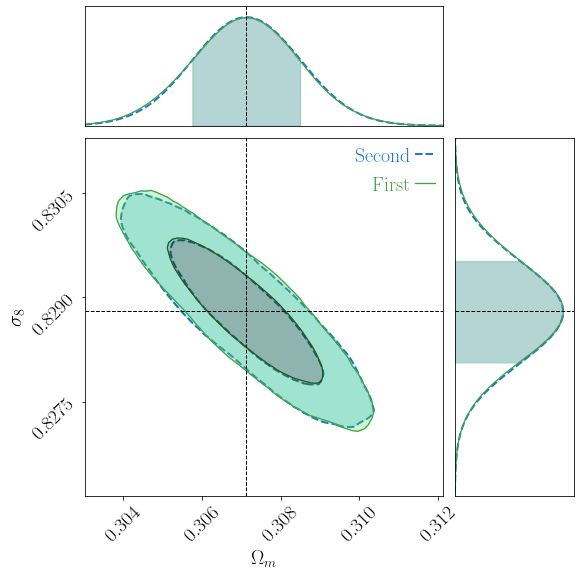

In [160]:
c = ChainConsumer()
c.add_chain(data_sec, name="Second", parameters = [r'$\Omega_m$',r'$\sigma_8$'])
c.add_chain(data_first, name="First", parameters = [r'$\Omega_m$',r'$\sigma_8$'])
c.configure(kde = [1.5,1.5,1.5,1.5], smooth=[1,1,1,1],linestyles=["--", "-", "-","-"],
            linewidths=[2, 1.3, 1.3, 1.3],
             colors=['b','g','r','k'], shade=[True, True, True,False], 
            shade_alpha = [0.3,.3, .1,1],
            bar_shade=True,
            flip=True,label_font_size=20, 
            tick_font_size=20)
fig = c.plotter.plot(truth = True_value)
fig.set_size_inches(5 + fig.get_size_inches()) 
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/forecast.png', bbox_inches='tight', dpi=300)

In [139]:
cov_first_derivative.diagonal()**.5

array([0.00125009, 0.00066266])